In [2]:
import pandas as pd
import numpy as np
import datetime
import os
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
import joblib
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score
import matplotlib
import matplotlib.pyplot as plt

# 한글 폰트 깨짐 해결
plt.rcParams["font.family"] = "Malgun Gothic"
# 마이너스 부호 깨짐 해결
matplotlib.rcParams['axes.unicode_minus']=False

In [28]:
# # 해당 디렉토리에 있는 개별 데이터 로드 후 통합
# directory_path = './Flight_data/'
# file_names = os.listdir(directory_path)
# data = pd.DataFrame()
# for file_name in file_names:
#     if file_name.endswith('.csv'):
#         file_path = os.path.join(directory_path, file_name)
#         temp = pd.read_csv(file_path,encoding='euc-kr')
#         data = pd.concat([data, temp])

# # 불필요한 데이터 제거 후 Flight.csv로 저장
# data.drop(labels=['+1일','편도'], axis=1,inplace=True)
# data['선택한 날짜'] = data['선택한 날짜'].astype(int)
# data.to_csv('./Flight.csv', index=False,encoding='euc-kr')

# Data Preprocessing

In [3]:
# 데이터 불러오기
data = pd.read_csv('./Flight.csv', encoding='euc-kr')
# 가독성 위해 컬럼명 변경
data = data.rename(columns={'운행정보1':'직항여부'})
# 출발 공항 이진 분류 설정
'''
0 : 입국 (프랑스 → 한국)
1 : 출국 (한국 → 프랑스)
'''
data['출국여부'] = data['출발공항'].apply(lambda x: 1 if x == 'ICN' else 0)
# 날짜 데이터 변환 및 년/월/일 분류
data['선택한 날짜'] = pd.to_datetime(data['선택한 날짜'], format='%Y%m%d')
data['년'] = data['선택한 날짜'].dt.year
data['월'] = data['선택한 날짜'].dt.month
data['일'] = data['선택한 날짜'].dt.day
# 요일 정보 추가
data['요일'] = data.apply(lambda x: datetime.date(x['년'], x['월'], x['일']).weekday(), axis=1)
# 3개월 후 여행을 계획하는지
'''가설 : 티켓팅을 빠르게 할 수록 저렴하게 여행이 가능하다'''
today = datetime.datetime.today().date()
target_date = today + datetime.timedelta(days=90)
data['3개월'] = (data['선택한 날짜'].dt.date >=target_date).astype(int)
# 출발 시간대 정보 추가
'''
네이버 항공권 사이트에선 출발 시각을 7가지로 분류 
0 : 새벽 (00:00 ~ 06:00)
1 : 오전 (06:00 ~ 09:00)
2 : 오전 (09:00 ~ 12:00)
3 : 오후 (12:00 ~ 15:00)
4 : 오후 (15:00 ~ 18:00)
5 : 저녁 (18:00 ~ 21:00)
6 : 저녁 (21:00 ~ 00:00)
'''
def time_func(x):
    temp = int(x.split(':')[0])
    if temp < 6: return 0
    elif temp < 9: return 1
    elif temp < 12: return 2
    elif temp < 15: return 3
    elif temp < 18: return 4
    elif temp < 21: return 5
    else : return 6
data['출발시간대'] = data['출발시간'].apply(time_func)
# data['도착시간대'] = data['도착시간'].apply(time_func)
# 직항 여부 binary 데이터 변경
'''
0 : 경유 (횟수 관계 없이)
1 : 직항
'''
data['직항여부'] = data['직항여부'].apply(lambda x: 1 if x =='직항' else 0)
# 데이터 추출
'''
직항인 항공권의 경우 티켓 별 가격 편차(대부분 사분위수 Q1에 속함)가 크지 않은 반면,
경유 비행하는 경우 가격 편차가 크다. (40만원 ~ 3000만원)
적은 수의 feature와 데이터를 사용하는 현재 프로젝트를 고려했을 때, 복잡한 모델은 구축하기 어려우며,
저가로 항공 서비스를 이용하기 위해 경유는 납득 가능하지만,
직항 항공권 가격보다 비싼 경유 항공을 이용할 이유는 없다고 생각했기 때문에, 
각 날짜별 직항 항공권의 최저가 보다 저렴한 경유 항공권 정보만 추출해 모델 학습에 사용하였음.
'''
preprocessed_data = pd.DataFrame()
for date in data['선택한 날짜'].unique():
    condition_0 = (data['선택한 날짜']==date) & (data['직항여부'] == 0)
    condition_1 = (data['선택한 날짜']==date) & (data['직항여부'] == 1)
    filtered_data_1 = data.loc[condition_1]
    min_price = min(filtered_data_1['가격'])
    filtered_data_0 = data.loc[condition_0]
    filtered_data_0 = filtered_data_0[filtered_data_0['가격'] < min_price]
    preprocessed_data = pd.concat([preprocessed_data,filtered_data_0, filtered_data_1])
# 학습에 사용할 데이터 추출
'''
현재 프로젝트에서는 인천 → 프랑스 / 프랑스 → 인천 두 가지 경우에 대해서만 학습을 진행함.
따라서 출발공항과 도착공항 feature를 사용하거나 One-hot encoding 작업 수행 없이 출국 여부로 변경하여 간결하게 변경.
※ 단, 다른 노선이 고려되는 경우엔 해당 방법을 이용할 수 없으며, One-hot encoding 또는 그 외 적절한 방법을 찾아야함.
'''
preprocessed_data = preprocessed_data[['년','월','일','요일','3개월','출국여부','출발시간대','직항여부','가격']] #'출발공항','도착공항'



# Machine Learning

In [4]:
features = ['년','월','일','요일','3개월','출국여부','출발시간대','직항여부']
target = '가격'
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data[features],preprocessed_data[target], test_size = 0.2, random_state = 42)
# One-hot encoding
'''
위에서 언급한 바와 같이, 현재 프로젝트에서는 출국여부로 대체되어 encoding 생략
'''
# encoder = OneHotEncoder(use_cat_names=True,handle_unknown='ignore')
# X_train_EN = encoder.fit_transform(X_train)
# X_test_EN = encoder.transform(X_test)
# encoder 저장
# joblib.dump(encoder, 'encoder.pkl')
# encoder 불러오기
# encoder = joblib.load('encoder.pkl')

'\n위에서 언급한 바와 같이, 현재 프로젝트에서는 출국여부로 대체되어 encoding 생략\n'

## Baseline 모델 생성

In [40]:
# Decision Tree
model_dt = DecisionTreeRegressor()

model_dt.fit(X_train, y_train)
pred_dt = model_dt.predict(X_test)
mae_dt = mae(y_test, pred_dt)
mse_dt = mse(y_test, pred_dt)
rmse_dt = mse(y_test, pred_dt,squared=False)
r2_dt = r2_score(y_test, pred_dt)

# RandomForest
model_rf = RandomForestRegressor()

model_rf.fit(X_train,y_train)
pred_rf = model_rf.predict(X_test)
mae_rf = mae(y_test, pred_rf)
mse_rf = mse(y_test, pred_rf)
rmse_rf = mse(y_test, pred_rf,squared=False)
r2_rf = r2_score(y_test, pred_rf)

# XGBoost
model_xgb = XGBRegressor()

model_xgb.fit(X_train,y_train)
pred_xgb = model_rf.predict(X_test)
mae_xgb = mae(y_test, pred_xgb)
mse_xgb = mse(y_test, pred_xgb)
rmse_xgb = mse(y_test, pred_xgb,squared=False)
r2_xgb = r2_score(y_test, pred_xgb)

# Support Vector Machine (SVM)
model_svm = SVR()

model_svm.fit(X_train,y_train)
pred_svm = model_rf.predict(X_test)
mae_svm = mae(y_test, pred_svm)
mse_svm = mse(y_test, pred_svm)
rmse_svm = mse(y_test, pred_svm,squared=False)
r2_svm = r2_score(y_test, pred_svm)

# Baseline 모델 결과 출력
baseline = {'Model': ['Decision Tree', 'Random Forest','XGBoost','SVM'], 'MAE': [mae_dt, mae_rf, mae_xgb,mae_svm], 'MSE': [mse_dt,mse_rf,mse_xgb,mse_svm],'RMSE':[rmse_dt,rmse_rf,rmse_xgb,rmse_svm],'R2':[r2_dt,r2_rf,r2_xgb,r2_svm]}
result_baseline = pd.DataFrame(baseline)
result_baseline = result_baseline.round(2)
display(result_baseline)

,Model,MAE,MSE,RMSE,R2
0,Decision Tree,140210.28,1.253612e+11,354063.83,0.37
1,Random Forest,131632.26,9.614797e+10,310077.37,0.52
2,XGBoost,131632.26,9.614797e+10,310077.37,0.52
3,SVM,131632.26,9.614797e+10,310077.37,0.52


## Feature Importance & Permutation Importance

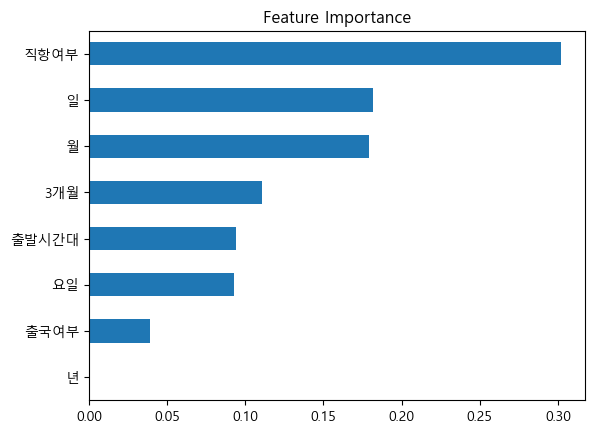

In [45]:
# Feature Importance
importances = pd.Series(model_rf.feature_importances_,X_train.columns)
importances.sort_values().plot.barh()
plt.title("Feature Importance")
plt.show;


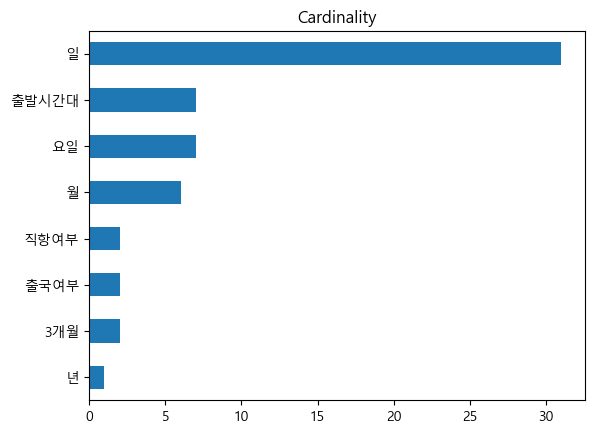

In [48]:
# Cardinality
X_train.nunique().sort_values().plot.barh()
plt.title("Cardinality")
plt.show;

#### 참고

- 초기 데이터(7월 ~ 10월)에선 가설(※)을 증명하기에 데이터가 부족하다고 판단했고,   
추가 데이터 수집(7월 ~ 12월) 후에 feature 중요도가 높아진 것을 확인할 수 있다.  
`※가설 :` `3개월 일찍 항공권을 구매하는 것이 비용 절감할 수 있다.`

`데이터 추가 수집 전`  

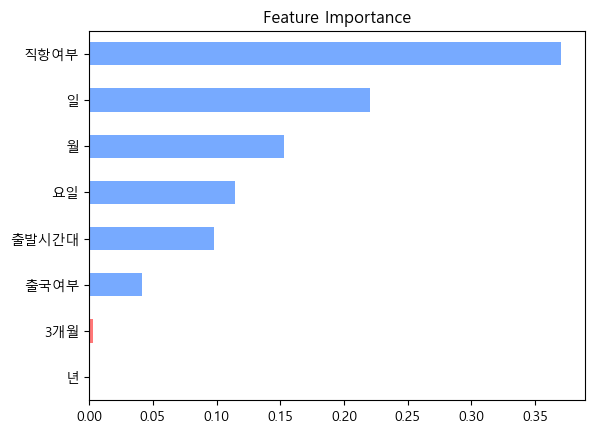  


`데이터 추가 수집 후`  

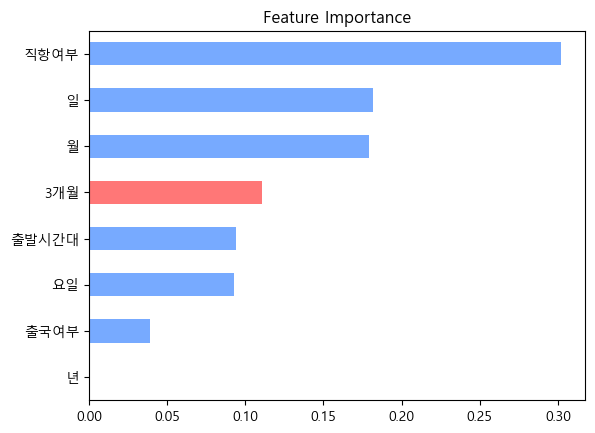

In [46]:
# Drop-Column Importance
score = model_rf.score(X_test,y_test)
print(f'Before Drop :: 검증 정확도 {score:.4f}')
dci = pd.Series(dtype=float)
for feature in features:
    model_rf.fit(X_train.drop(columns=[feature], axis=1), y_train)
    score_dropped = model_rf.score(X_test.drop(columns=[feature], axis=1), y_test)
    print(f"Drop {feature} :: 검증 정확도 {score_dropped:.4f}")

    dci[feature] = score - score_dropped

Before Drop :: 검증 정확도 0.5206
Drop 년 :: 검증 정확도 0.5212
Drop 월 :: 검증 정확도 0.5055
Drop 일 :: 검증 정확도 0.4222
Drop 요일 :: 검증 정확도 0.5492
Drop 3개월 :: 검증 정확도 0.5182
Drop 출국여부 :: 검증 정확도 0.4430
Drop 출발시간대 :: 검증 정확도 0.5888
Drop 직항여부 :: 검증 정확도 0.3758


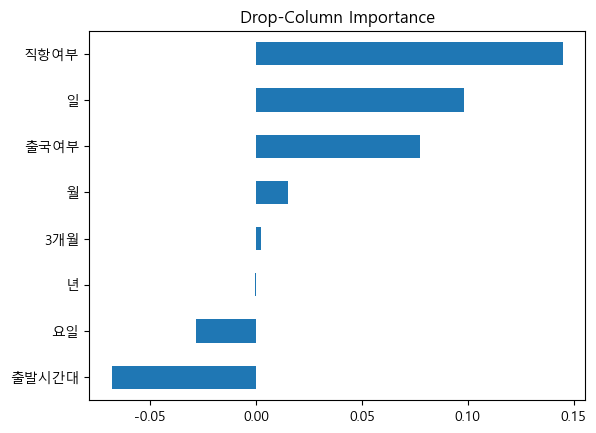

In [49]:
dci.sort_values().plot.barh()
plt.title("Drop-Column Importance")
plt.show();

#### 참고
- 마찬가지로 수집 전과 비교했을 때 feature 중요도 계산에 변화가 생겼음  
  
`데이터 추가 수집 전`  

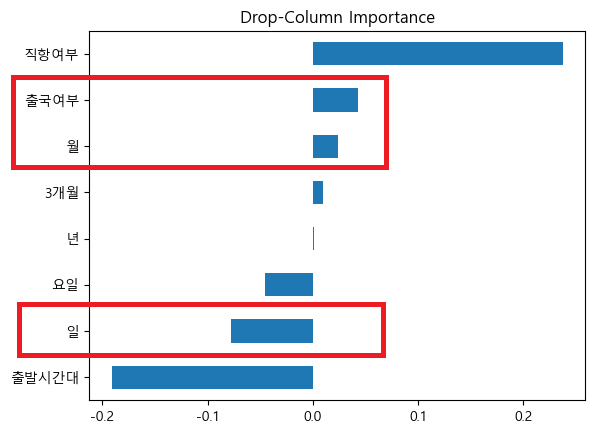

In [51]:
# Permutation Importance

model_rf.fit(X_train,y_train)

pi = pd.Series(dtype=float)

n_iter = 10  # 랜덤으로 특성을 섞어 평가 성능을 확인하는 과정을 몇 번 반복할지 결정
np.random.seed(2) # random seed를 고정하여 반복적으로 아래 코드를 수행해도 같은 결과가 나오게 함

for feature in features:
    X_test_permed = X_test.copy()

    # 모델을 재학습하지 않고, 기존 모델에서 feature 값을 여러 번(n_iter) 섞고 검증하여 평균 성능 확인.
    scores_permutated = []
    for _ in range(n_iter):
        X_test_permed[feature] = np.random.permutation(X_test_permed[feature])
        scores_permutated.append(model_rf.score(X_test_permed, y_test))
    avg_score_permutated = np.mean(scores_permutated)
    print(f"Perm {feature} :: 검증 정확도 {avg_score_permutated:.4f}")

    # permutation importance는 해당 특성을 랜덤으로 섞었을 때의 성능 하락폭으로 정의됩니다.
    pi[feature] = score - avg_score_permutated

Perm 년 :: 검증 정확도 0.5184
Perm 월 :: 검증 정확도 0.2919
Perm 일 :: 검증 정확도 0.4094
Perm 요일 :: 검증 정확도 0.5108
Perm 3개월 :: 검증 정확도 0.3933
Perm 출국여부 :: 검증 정확도 0.4073
Perm 출발시간대 :: 검증 정확도 0.4411
Perm 직항여부 :: 검증 정확도 -0.1151


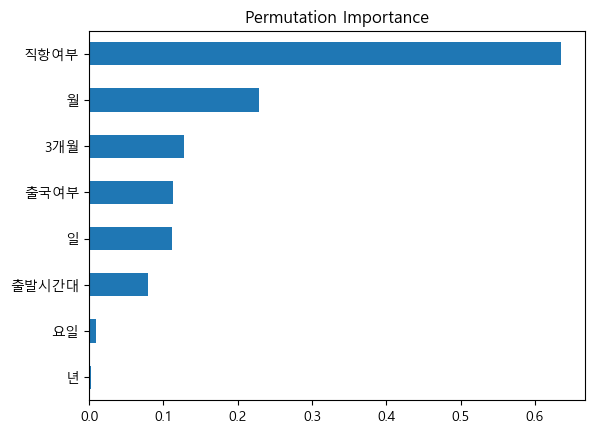

In [53]:
pi.sort_values().plot.barh()
plt.title("Permutation Importance")
plt.show();

#### 참고
- 마찬가지로 수집 전과 비교했을 때 feature 중요도 계산에 변화가 생겼음  
  
`데이터 추가 수집 전`  

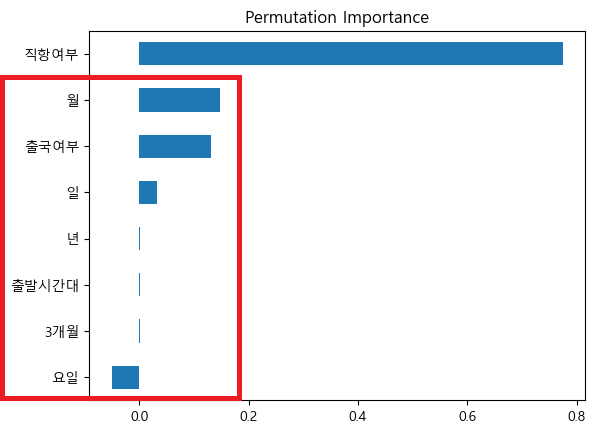

# Feature 재선택 후 성능 계산
- `요일`, `년도`, `출발시간대`를 제거하며 성능을 테스트 수행  
-  코드 실행마다 약간의 성능변화는 있었지만, 성능은 개선되었음.

#### Test Result  

| Removed Feature | RMSE | R2 |
|-----|-----|-----|
| baseline | 31만원 | 0.52 |
| 년도 | 31만원 | 0.52 |
| 요일 | 30.2만원 | 0.54 |
| 출발시간대 | 29.2만원 | 0.57 |
| 요일, 출발시간대 | 28.4만원 | 0.60 |
| 년도, 요일, 출발시간대 | 28.4만원 | 0.60 |

In [63]:
features = ['월','일','3개월','출국여부','직항여부']
target = '가격'
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data[features],preprocessed_data[target], test_size = 0.2, random_state = 42)

# Decision Tree
model_dt = DecisionTreeRegressor()

model_dt.fit(X_train, y_train)
pred_dt = model_dt.predict(X_test)
mae_dt = mae(y_test, pred_dt)
mse_dt = mse(y_test, pred_dt)
rmse_dt = mse(y_test, pred_dt,squared=False)
r2_dt = r2_score(y_test, pred_dt)

# RandomForest
model_rf = RandomForestRegressor()

model_rf.fit(X_train,y_train)
pred_rf = model_rf.predict(X_test)
mae_rf = mae(y_test, pred_rf)
mse_rf = mse(y_test, pred_rf)
rmse_rf = mse(y_test, pred_rf,squared=False)
r2_rf = r2_score(y_test, pred_rf)

# XGBoost
model_xgb = XGBRegressor()

model_xgb.fit(X_train,y_train)
pred_xgb = model_rf.predict(X_test)
mae_xgb = mae(y_test, pred_xgb)
mse_xgb = mse(y_test, pred_xgb)
rmse_xgb = mse(y_test, pred_xgb,squared=False)
r2_xgb = r2_score(y_test, pred_xgb)

# Support Vector Machine (SVM)
model_svm = SVR()

model_svm.fit(X_train,y_train)
pred_svm = model_rf.predict(X_test)
mae_svm = mae(y_test, pred_svm)
mse_svm = mse(y_test, pred_svm)
rmse_svm = mse(y_test, pred_svm,squared=False)
r2_svm = r2_score(y_test, pred_svm)

# Baseline 모델 결과 출력
baseline = {'Model': ['Decision Tree', 'Random Forest','XGBoost','SVM'], 'MAE': [mae_dt, mae_rf, mae_xgb,mae_svm], 'MSE': [mse_dt,mse_rf,mse_xgb,mse_svm],'RMSE':[rmse_dt,rmse_rf,rmse_xgb,rmse_svm],'R2':[r2_dt,r2_rf,r2_xgb,r2_svm]}
result_baseline = pd.DataFrame(baseline)
result_baseline = result_baseline.round(2)
display(result_baseline)

,Model,MAE,MSE,RMSE,R2
0,Decision Tree,134786.42,8.826556e+10,297095.21,0.56
1,Random Forest,131937.43,8.061610e+10,283929.75,0.60
2,XGBoost,131937.43,8.061610e+10,283929.75,0.60
3,SVM,131937.43,8.061610e+10,283929.75,0.60


# AutoML
#### 참고 
https://preservsun.tistory.com/entry/Pycaret-%EC%84%A4%EC%B9%98-%EC%BD%94%EB%93%9C-%ED%8C%8C%EC%9D%B4%EC%8D%ACpython-AutoML-%EA%B5%AC%ED%98%84-%EC%98%88%EC%A0%9C

In [1]:
from pycaret.regression import *

In [17]:
# features = ['년','월','일','요일','3개월','출국여부','출발시간대','직항여부']
features = ['월','일','3개월','출국여부','직항여부','가격'] # 년/요일/출발시간대
target = '가격'
# X_train, X_test, y_train, y_test = train_test_split(preprocessed_data[features],preprocessed_data[target], test_size = 0.2, random_state = 42)
# train, test = train_test_split(preprocessed_data, test_size = 0.2, random_state = 42)

In [ ]:
setup(data=preprocessed_data[features], target=target, use_gpu=True)

#### 참고  
  
- 학습에 맞게 데이터 설정  
  
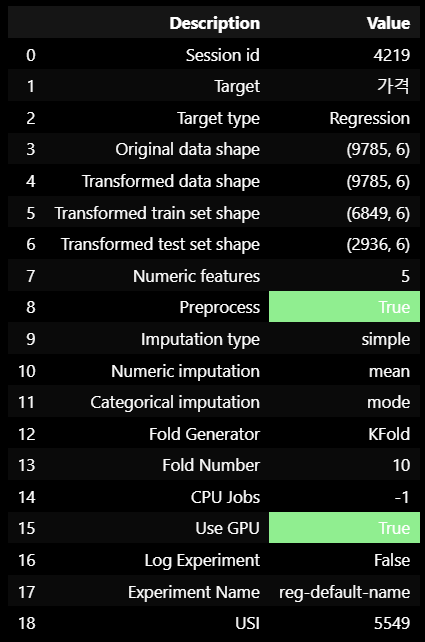

In [19]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,131834.3353,75999552356.1906,271828.9281,0.6151,0.1714,0.1270,1.3030
gbr,Gradient Boosting Regressor,145607.7866,87296674292.6130,291030.5847,0.5597,0.1882,0.1421,0.4770
knn,K Neighbors Regressor,140846.5028,91727806756.2093,299014.0503,0.5337,0.1892,0.1333,0.1630
rf,Random Forest Regressor,135901.5823,93594573954.5417,299439.0138,0.5253,0.1773,0.1280,0.5790
xgboost,Extreme Gradient Boosting,135807.6473,97654590753.3173,305115.4096,0.5031,0.1771,0.1277,0.6920
et,Extra Trees Regressor,137896.1548,101824081954.9868,311441.2275,0.4810,0.1802,0.1290,0.5310
dt,Decision Tree Regressor,138511.9662,102510579978.5617,312577.2058,0.4772,0.1807,0.1294,0.1300
br,Bayesian Ridge,176566.8197,107435332827.8122,323665.6907,0.4558,0.2225,0.1756,0.1220
llar,Lasso Least Angle Regression,176592.7265,107435831665.6115,323670.4208,0.4558,0.2225,0.1757,0.1170
lar,Least Angle Regression,176593.1522,107435833142.7177,323670.4595,0.4558,0.2225,0.1757,0.1170


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [ ]:
models()

#### 참고  

- 학습에 사용된 모델 리스트 출력  
  
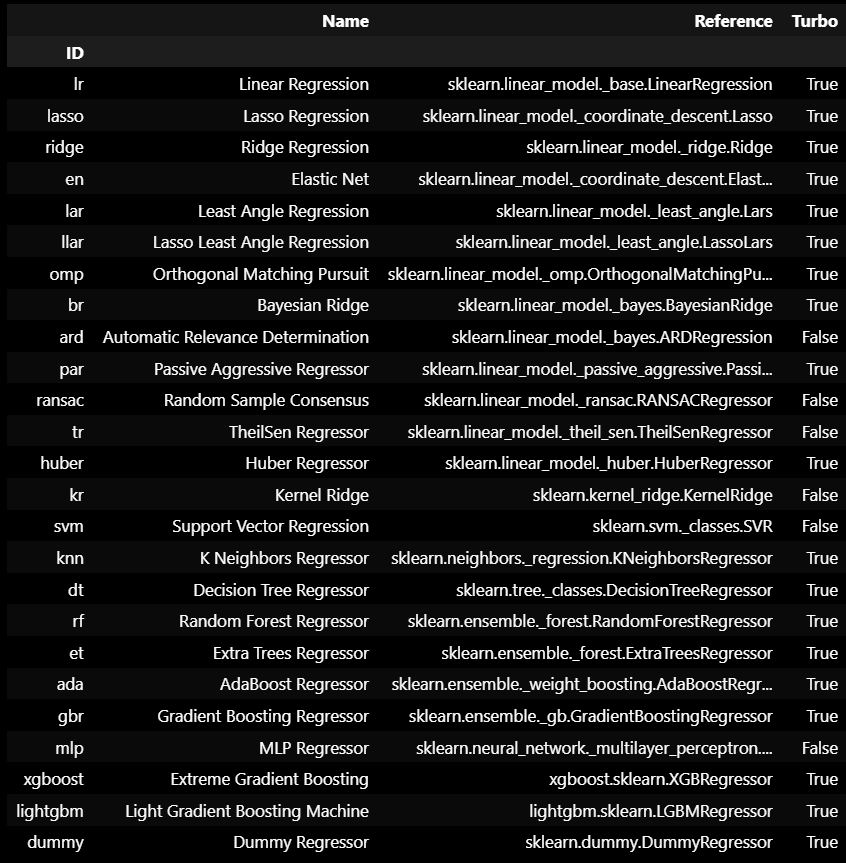

In [23]:
# 해당 모델을 가져오고 cross-validation을 통한 성능 확인 가능
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,130433.8127,90912178108.1002,301516.4641,0.6444,0.1658,0.1200
1,133528.3590,100308007818.2634,316714.3947,0.5714,0.1723,0.1213
2,121208.9754,68746551057.1874,262195.6351,0.5900,0.1617,0.1213
3,140267.5073,113729929785.5910,337238.6837,0.5400,0.1833,0.1301
4,123270.0777,49397829416.7634,222256.2247,0.6052,0.1695,0.1275
5,118009.5058,37678540873.3927,194109.6105,0.7156,0.1572,0.1220
6,128040.6186,47548814216.9750,218056.9059,0.7004,0.1717,0.1314
7,136675.1072,66079705146.4306,257059.7307,0.6499,0.1731,0.1313
8,145399.9287,96327987500.6112,310367.5039,0.5344,0.1877,0.1382


In [ ]:
# Random Grid Search를 사용해 하이퍼파라미터 탐색
'''성능이 떨어져서 기존 lightgbm 사용'''
tuned_lightgbm = tune_model(lightgbm)
# 훈련된 모델의 하이퍼파라미터
print(tuned_lightgbm.get_params)
# Baggin 기반 ensemble model 생성
'''성능 하락으로 기존 lightgbm 사용'''
ensembled_lightgbm = ensemble_model(lightgbm)
# Feature Importance 확인
plot_model(lightgbm, plot='feature')
plt.show()

In [34]:
# 모델 예측 수행
predict_model(lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,133272.8870,92160733407.1162,303579.8633,0.6137,0.1702,0.1258


,월,일,3개월,출국여부,직항여부,가격,prediction_label
32452,9,22,0,1,0,1361600,1.290658e+06
45052,10,10,0,1,0,758800,7.575598e+05
50458,11,1,1,0,0,747600,7.626853e+05
31411,9,18,0,1,0,1010300,8.614653e+05
28979,9,10,0,1,0,839100,8.981502e+05
...,...,...,...,...,...,...,...
90036,12,30,1,1,0,755377,7.290917e+05
7328,8,22,0,0,0,897000,9.460633e+05
61987,11,26,1,0,1,971200,1.169357e+06
32704,9,23,0,1,0,1447500,1.220445e+06


In [35]:
final_lightgbm = finalize_model(lightgbm)

In [54]:
from pycaret.regression import *
# from pycaret.regression import save_model, load_model
# 모델 저장
save_model(final_lightgbm, 'Flight_ML')
# 모델과 전처리 파이프라인 저장
# save_model(final_lightgbm, 'Flight_ML', model_only=False)
# 모델 불러오기
Flight_ML = load_model('Flight_ML')


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


In [53]:
# ['월','일','3개월','출국여부','직항여부','가격']
# Test
test = pd.DataFrame([[7, 27, 0, 1, 1],[8,9,0,1,1],[8,9,0,0,1]], columns=['월', '일', '3개월', '출국여부', '직항여부'])
predict_model(final_lightgbm, data = test)

,월,일,3개월,출국여부,직항여부,prediction_label
0,7,27,0,1,1,1.092470e+06
1,8,9,0,1,1,1.252479e+06
2,8,9,0,0,1,2.257467e+06


In [56]:
predict_model(Flight_ML, data = test)['prediction_label']

0    1.092470e+06
1    1.252479e+06
2    2.257467e+06
Name: prediction_label, dtype: float64

In [36]:
final_lightgbm

Pipeline(memory=FastMemory(location=C:\Users\pc\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['월', '일', '3개월', '출국여부', '직항여부'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ('actual_estimator',
                 LGBMRegressor(device='gpu', n_jobs=-1, random_state=4219))])

In [28]:
lightgbm.get_params

<bound method LGBMModel.get_params of LGBMRegressor(device='gpu', n_jobs=-1, random_state=4219)>